In [488]:
import numpy as np

import cvxpy as cp
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
import opt
import sev_filters_opt
from data import pert_S

In [489]:
def error_metrics(Y_hat, Y_test, H=None, H_gt=None, print_results=True, attrs=None):
    # Normalized error
    if Y_test.ndim == 2:
        norm_sq_y = (Y_test**2).sum(1)#np.sqrt((Y_test**2).sum(1))
        err_y = np.mean(((Y_test - Y_hat)**2).sum(1) / norm_sq_y)
    else:
        norm_y = (Y_test**2).sum((1,2))#np.sqrt((Y_test**2).sum(1))
        err_ys = ((Y_test - Y_hat)**2).sum((1,2)) / norm_y
        err_y = np.mean(err_ys)
    
    if print_results:
        print(f"Error in signal y: {err_y}")
        if Y_test.ndim == 3 and attrs is not None:
            print("Error in each attribute")
            for i in range(Y_test.shape[0]):
                print(f"{attrs[i]} - {err_ys[i]}")

    if H is not None and H_gt is not None:
        # Error wrt ground truth filter
        if H.ndim == 3: # Several filters
            norm_H = (H_gt**2).sum((1,2))
            err_H = np.mean(((H - H_gt)**2).sum((1,2)) / norm_H)
        else:
            norm_sq_H = (H_gt**2).sum()
            err_H = ((H - H_gt)**2).sum() / norm_sq_H

        if print_results:
            print(f"Error in filter: {err_H}")
        return err_y, err_H

    return err_y

In [490]:
def plot_filters(Hs):
    n_filt = Hs.shape[0]
    f, ax = plt.subplots(1, n_filt, figsize=(12,8))

    for i in range(n_filt):    
        ax[i].imshow(Hs[i,:,:])

# Reading the data

In [491]:
#data = np.load('data_temp/temperatures2003_mod_knn8_N40.npz')
data = np.load('data_temp/temperatures2018_knn8_N28.npz') # 54 for only valid values, 36 for invalid values as well
data = np.load('data_temp/temperatures2018_knn5_N31.npz')

# Multiple filters for multiple data

In [492]:
A = data['A_bin']
N = A.shape[0]

pert_graph = False
if pert_graph:
    A = pert_S(A, eps=0.1) # Using default parameters rewire 10% of total links

random_A = False
if random_A:
    A = (np.random.rand(N, N) > 0.8).astype(int)
    A_triu = np.triu(A, 1)
    A = A_triu + A_triu.T

norm_A = np.sqrt((A**2).sum())

attrs = [
"Temperatures",
#"Precipitation",
"Wind Speed",
"Station Pressure"
]
X1 = data['temps'].copy()
X2 = data['precs'].copy()
X3 = data['windsps'].copy()
X4 = data['press'].copy()
comp_data = np.array([
    X1,
#    X2,
    X3,
    X4
])
n_feat, N, N_dates = comp_data.shape
N_dates -= 1

norm_data = True
if norm_data:
    comp_data = comp_data / np.sqrt((comp_data**2).sum(2))[:,:,None]

Ys = comp_data[:,:,1:].copy()
Xs = comp_data[:,:,:-1].copy()
Xs.shape, Ys.shape

((2, 31, 364), (2, 31, 364))

In [493]:
(comp_data**2).sum(2)

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

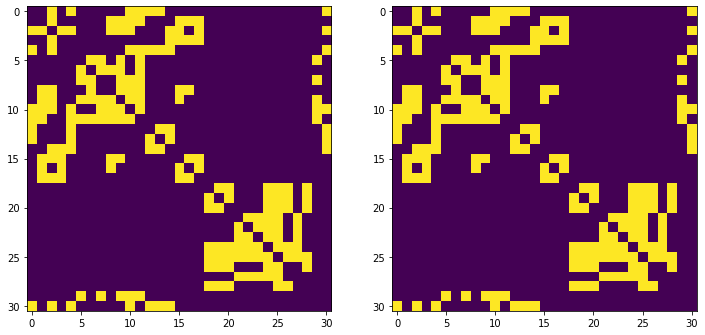

In [494]:
plot_filters(np.array([data['A_bin'], A]))

In [495]:
train_test_split = 0.5

random_train_test = False
if random_train_test:
    idxs = np.random.permutation(N_dates)
else:
    idxs = np.arange(N_dates)

idxs_train = idxs[:int(train_test_split*N_dates)]
idxs_test = idxs[int(train_test_split*N_dates):]

Xs_train = Xs[:,:,idxs_train]
Ys_train = Ys[:,:,idxs_train]
Xs_test = Xs[:,:,idxs_test]
Ys_test = Ys[:,:,idxs_test]
Xs_train.shape, Ys_train.shape, Xs_test.shape, N_dates

((2, 31, 182), (2, 31, 182), (2, 31, 182), 364)

In [496]:
models = []
errs_y = []
errs_H = []

In [497]:
Hs_gt = []
for i in range(n_feat):
    H = cp.Variable((N,N))
    obj = cp.sum_squares(Ys_test[i,:,:] - H @ Xs_test[i,:,:])
    prob = cp.Problem(cp.Minimize(obj))
    prob.solve()
    Hs_gt.append(H.value)
Hs_gt = np.array(Hs_gt)

In [498]:
Ys_hat_gt = Hs_gt @ Xs_test
err_y_gt, err_H_gt = error_metrics(Ys_hat_gt, Ys_test, Hs_gt, Hs_gt, attrs=attrs)
models.append("Least Squares (LB)"); errs_y.append(err_y_gt); errs_H.append(err_H_gt)
err_y_gt, err_H_gt

Error in signal y: 0.04177788806224478
Error in each attribute
Temperatures - 0.0012448741637118951
Wind Speed - 0.08231090196077766
Error in filter: 0.0


(0.04177788806224478, 0.0)

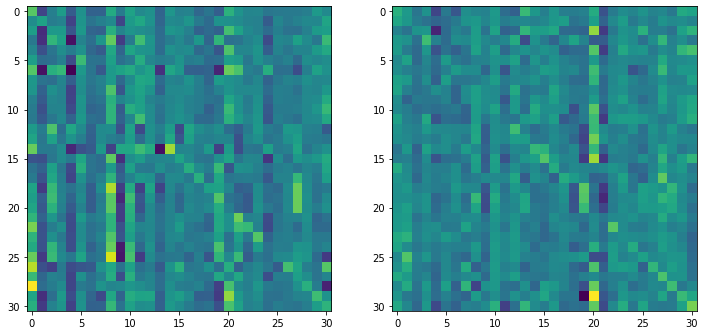

In [499]:
plot_filters(Hs_gt)

# Eye model

In [500]:
# Identity - copying the temperature from the previous day
Hs_eye = np.array([np.eye(N) for _ in range(n_feat)])
Ys_eye = Hs_eye @ Xs_test
err_y_eye, err_H_eye = error_metrics(Ys_eye, Ys_test, Hs_eye, Hs_gt, attrs=attrs)
models.append("Copy Prev Day"); errs_y.append(err_y_eye); errs_H.append(err_H_eye)

Error in signal y: 0.07806811835349217
Error in each attribute
Temperatures - 0.00199917503969317
Wind Speed - 0.1541370616672912
Error in filter: 1.2483556797037039


## Least squares

In [501]:
Hs_ls = []
for i in range(n_feat):
    H = cp.Variable((N,N))
    obj = cp.sum_squares(Ys_train[i,:,:] - H @ Xs_train[i,:,:])
    prob = cp.Problem(cp.Minimize(obj))
    prob.solve()
    Hs_ls.append(H.value)
Hs_ls = np.array(Hs_ls)

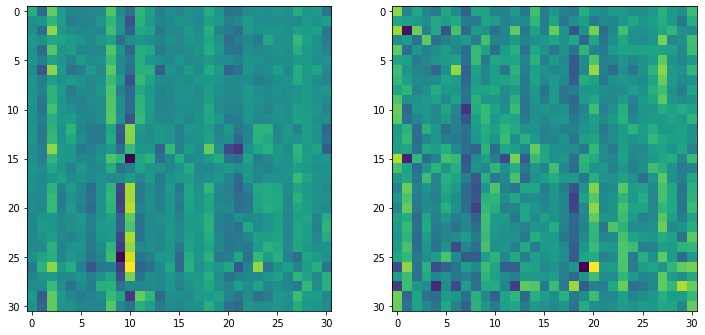

In [502]:
plot_filters(Hs_ls)

In [503]:
Ys_hat_ls = Hs_ls @ Xs_test
err_y_ls, err_H_ls = error_metrics(Ys_hat_ls, Ys_test, Hs_ls, Hs_gt, attrs=attrs)
models.append("Least Squares"); errs_y.append(err_y_ls); errs_H.append(err_H_ls)
err_y_ls, err_H_ls

Error in signal y: 0.06756999663113068
Error in each attribute
Temperatures - 0.0034983594725779684
Wind Speed - 0.1316416337896834
Error in filter: 1.728817799591475


(0.06756999663113068, 1.728817799591475)

In [504]:
# Least squares postulating it is a graph filter
K = 5
Spow = np.array([np.linalg.matrix_power(A, k) for k in range(K)])
Hs_ls_gf = []
for i in range(n_feat):
    h = cp.Variable(K)
    obj = cp.sum_squares(Ys_train[i,:,:] - cp.sum([h[k] * Spow[k,:,:] for k in range(K)]) @ Xs_train[i,:,:])
    prob = cp.Problem(cp.Minimize(obj))
    prob.solve()
    h = h.value
    Hs_ls_gf.append(np.sum([h[k] * Spow[k,:,:] for k in range(K)], 0))
Hs_ls_gf = np.array(Hs_ls_gf)

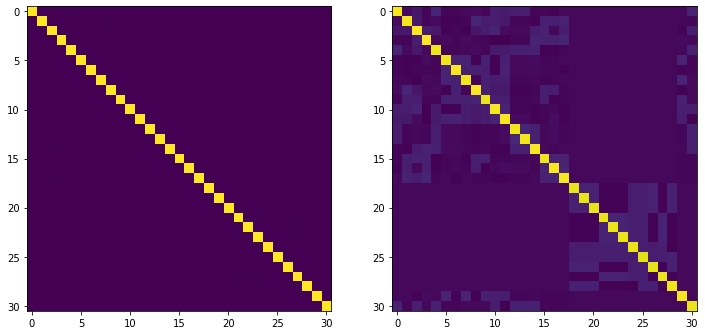

In [505]:
plot_filters(Hs_ls_gf)

In [506]:
Ys_hat_ls_gf = Hs_ls_gf @ Xs_test
err_y_ls_gf, err_H_ls_gf = error_metrics(Ys_hat_ls_gf, Ys_test, Hs_ls, Hs_gt, attrs=attrs)
models.append("LS-GF"); errs_y.append(err_y_ls_gf); errs_H.append(err_H_ls_gf)
err_y_ls_gf, err_H_ls_gf

Error in signal y: 0.07010003777473309
Error in each attribute
Temperatures - 0.001992691141039738
Wind Speed - 0.13820738440842645
Error in filter: 1.728817799591475


(0.07010003777473309, 1.728817799591475)

## Iterative (robust) algorithms

In [507]:
args = [0.4, 0.008, 0.0005, 3.]
args_no_st = [0.03, 0.005, 0., 3.5]
args_rew = [0.2, 0.1, 0.001, 0.0001, 1.1]
args_rew_no_st = [0.1, 0.08, 0., 5e-4, 1.]

In [508]:
meanX = comp_data.mean(2)
stdX = comp_data.std(2)
Cs = np.zeros((n_feat, N, N))
for i in range(n_feat):
    X_norm = (comp_data[i,:,:].T - meanX[i,:]) / stdX[i,:]

    X_norm = np.where(np.isnan(X_norm), comp_data[i,:,:].T, X_norm)
    
    Cs[i,:,:] = np.cov(X_norm.T)

In [509]:
Hs_iter = []
Ss_iter = []
for i in range(n_feat):
    _, H, S_iter = opt.estH_iter(Xs[i,:,:], Ys[i,:,:], A, Cs[i,:,:], args)
    Hs_iter.append(H)
    Ss_iter.append(S_iter)
Hs_iter = np.array(Hs_iter)
S_iter = np.mean(np.array(Ss_iter), 0)

In [510]:
((S_iter - A)**2).sum() / norm_A

4.7692186260221446e-12

In [511]:
((S_iter - data['A_bin'])**2).sum() / norm_A

4.7692186260221446e-12

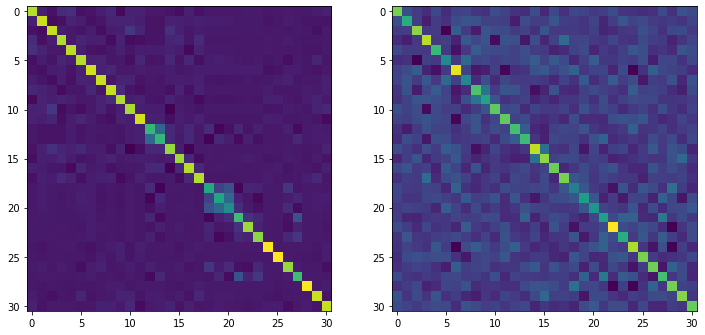

In [512]:
plot_filters(Hs_iter)

In [513]:
Ys_hat_iter = Hs_iter @ Xs_test
err_ys_iter, err_Hs_iter = error_metrics(Ys_hat_iter, Ys_test, Hs_iter, Hs_gt, attrs=attrs)
models.append("RGFI"); errs_y.append(err_ys_iter); errs_H.append(err_Hs_iter)
err_ys_iter, err_Hs_iter

Error in signal y: 0.058517762795809336
Error in each attribute
Temperatures - 0.0018997597995315469
Wind Speed - 0.11513576579208712
Error in filter: 0.9451480333050649


(0.058517762795809336, 0.9451480333050649)

## Iterative joint algs

In [514]:
import sev_filters_opt

In [515]:
args = [0.2, 1e-3, 0.02, 1.6]
args = [18, 0.02, 0.03, 5]
args_no_st = [0.4, 1e-3, 0., 1.5]
args_rew = [0.07, 1e-3, 0.1, 5e-4, 3.]
args_rew_no_st = [0.02, 1e-4, 0., 5e-4, 2.]

In [516]:
iter, Hs_iter_j, S_iter_j = sev_filters_opt.estHs_iter(Xs_train, Ys_train, A, Cs, args)

In [517]:
((S_iter_j - A)**2).sum() / norm_A

3.4616890840042735e-11

In [518]:
((S_iter_j - data['A_bin'])**2).sum() / norm_A

3.4616890840042735e-11

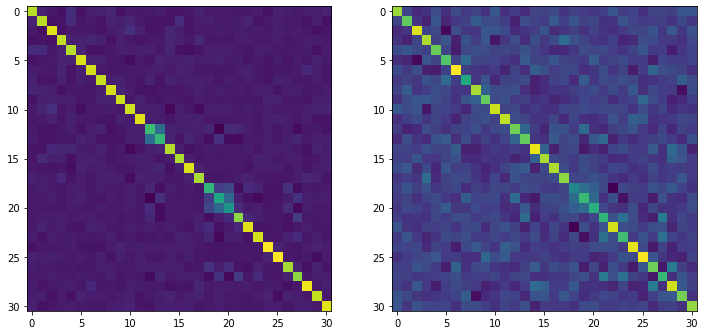

In [519]:
plot_filters(Hs_iter_j)

In [520]:
Ys_hat_iter_j = Hs_iter_j @ Xs_test
err_ys_iter_j, err_Hs_iter_j = error_metrics(Ys_hat_iter_j, Ys_test, Hs_iter_j, Hs_gt, attrs=attrs)
models.append("RGFI-J"); errs_y.append(err_ys_iter_j); errs_H.append(err_Hs_iter_j)
err_ys_iter_j, err_Hs_iter_j

Error in signal y: 0.0610820273421354
Error in each attribute
Temperatures - 0.0018754725840913118
Wind Speed - 0.1202885821001795
Error in filter: 0.9746266433792664


(0.0610820273421354, 0.9746266433792664)

# Representation

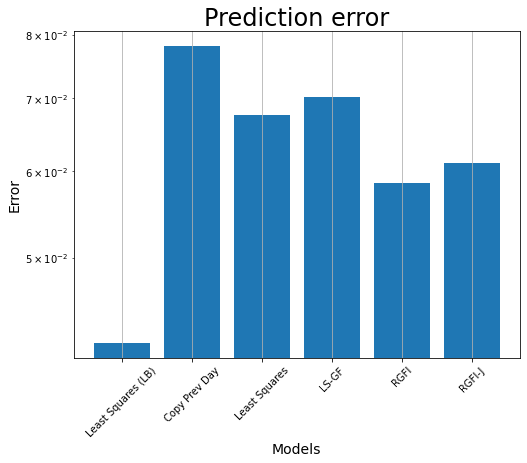

In [521]:
x_ax = np.arange(len(models))
plt.figure(figsize=(8,6))
plt.bar(x_ax, errs_y, log=True)
plt.xticks(x_ax, models, rotation=45)
plt.title("Prediction error", fontsize=24)
plt.xlabel("Models", fontsize=14)
plt.ylabel("Error", fontsize=14)
plt.grid()